In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.Sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            # layer = GENConv(channel_ls[i], channel_ls[i+1], aggr='powermean', learn_p=True, edge_dim=1)
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.8, gamma=0.8, dropout=0.3):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        # forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        # input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))

        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.7, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss


def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [11]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=64)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=36)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


21236456

In [17]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    beta = 1
    up_gamma = 1
    down_gamma = 1
    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / ((epoch + completed_epochs + 1) ** 0.2)


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_batch_loss.append(down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]))
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss = torch.mean(torch.stack(down_batch_loss))
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            up_batch_loss = []

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_batch_loss.append(up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight))
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            del up_batch_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'epoch {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [18]:
up_changer, down_changer, loss_log = train(400, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 3/3 [00:24<00:00,  8.30s/it]


epoch 0: down loss = 0.030024065946539242, up loss = 0.030425958335399628, down adj mae = 0.14461731414000192, up adj mae = 0.14665200312932333


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 1: down loss = 0.029479655126730602, up loss = 0.029343317573269207, down adj mae = 0.1425702820221583, up adj mae = 0.1459758679072062


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 2: down loss = 0.040722486873467766, up loss = 0.03197929635643959, down adj mae = 0.14393226305643717, up adj mae = 0.14645754794279733


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 3: down loss = 0.03550222019354502, up loss = 0.030474945281942684, down adj mae = 0.14260918398698172, up adj mae = 0.1454682101806005


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 4: down loss = 0.030026719594995182, up loss = 0.029310996333758037, down adj mae = 0.14214934408664703, up adj mae = 0.1440854867299398


100%|██████████| 3/3 [00:22<00:00,  7.66s/it]


epoch 5: down loss = 0.030292852471272152, up loss = 0.029319651424884796, down adj mae = 0.14345523218313852, up adj mae = 0.14722048739592233


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 6: down loss = 0.03017690156896909, up loss = 0.02943376948436101, down adj mae = 0.14532298843065897, up adj mae = 0.1481166978677114


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 7: down loss = 0.029708751166860264, up loss = 0.029557347918550175, down adj mae = 0.14352426926294962, up adj mae = 0.1469885210196177


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 8: down loss = 0.03377136463920275, up loss = 0.03060850252707799, down adj mae = 0.14503787954648337, up adj mae = 0.14924673239390054


100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


epoch 9: down loss = 0.030439964185158413, up loss = 0.025272322818636894, down adj mae = 0.14331614474455515, up adj mae = 0.14511575301488241


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 10: down loss = 0.03256043543418249, up loss = 0.026088882237672806, down adj mae = 0.14111600319544473, up adj mae = 0.14635634422302246


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 11: down loss = 0.02861962529520194, up loss = 0.025137991334001224, down adj mae = 0.14352561036745706, up adj mae = 0.143966073791186


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 12: down loss = 0.044257830207546554, up loss = 0.027044783035914104, down adj mae = 0.14357971648375192, up adj mae = 0.1508355736732483


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 13: down loss = 0.03455346077680588, up loss = 0.026544397075970966, down adj mae = 0.14266169567902884, up adj mae = 0.14734955628712973


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 14: down loss = 0.03231545972327391, up loss = 0.02569260572393735, down adj mae = 0.1437984953324, up adj mae = 0.14636064569155374


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 15: down loss = 0.031638861944278084, up loss = 0.02588729312022527, down adj mae = 0.14306178192297617, up adj mae = 0.14598777890205383


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 16: down loss = 0.031146661068002384, up loss = 0.025384350990255673, down adj mae = 0.14540119469165802, up adj mae = 0.14808777471383414


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 17: down loss = 0.028736040617028873, up loss = 0.02564353620012601, down adj mae = 0.14158479869365692, up adj mae = 0.14519822597503662


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 18: down loss = 0.03652964408198992, up loss = 0.027244887004295986, down adj mae = 0.14264067014058432, up adj mae = 0.14724465211232504


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 19: down loss = 0.03308017427722613, up loss = 0.02631859729687373, down adj mae = 0.14304438730080923, up adj mae = 0.14759096999963126


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 20: down loss = 0.03717151780923208, up loss = 0.026387309655547142, down adj mae = 0.1432222972313563, up adj mae = 0.14758124450842539


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 21: down loss = 0.03706609457731247, up loss = 0.025893337403734524, down adj mae = 0.1437001427014669, up adj mae = 0.14613748093446097


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 22: down loss = 0.03154337219893932, up loss = 0.0257751972724994, down adj mae = 0.14471116662025452, up adj mae = 0.1479720671971639


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 23: down loss = 0.03410264539221922, up loss = 0.0255837378402551, down adj mae = 0.14335144062836966, up adj mae = 0.14509367446104685


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 24: down loss = 0.029533392439285915, up loss = 0.02507121053834756, down adj mae = 0.14409741759300232, up adj mae = 0.14607045551141104


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 25: down loss = 0.03059421790142854, up loss = 0.02556387335062027, down adj mae = 0.14390999575455984, up adj mae = 0.1465307722489039


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 26: down loss = 0.035330865532159805, up loss = 0.02728079880277316, down adj mae = 0.14393498003482819, up adj mae = 0.14810694257418314


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 27: down loss = 0.03076920658349991, up loss = 0.02578754350543022, down adj mae = 0.1426237722237905, up adj mae = 0.14478936791419983


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 28: down loss = 0.03022476223607858, up loss = 0.024850125114123028, down adj mae = 0.14228513836860657, up adj mae = 0.14380711813767752


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 29: down loss = 0.035511588056882225, up loss = 0.025873453666766483, down adj mae = 0.14365866780281067, up adj mae = 0.1464398205280304


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 30: down loss = 0.03096398028234641, up loss = 0.026185571526487667, down adj mae = 0.1437403162320455, up adj mae = 0.14732899765173593


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 31: down loss = 0.034535364558299385, up loss = 0.025853607803583145, down adj mae = 0.1442075272401174, up adj mae = 0.14543808003266653


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 32: down loss = 0.03343733151753744, up loss = 0.025473981474836666, down adj mae = 0.14351053535938263, up adj mae = 0.1459853251775106


100%|██████████| 3/3 [00:23<00:00,  7.70s/it]


epoch 33: down loss = 0.03130544349551201, up loss = 0.026076285789410274, down adj mae = 0.14565669993559519, up adj mae = 0.14736384650071463


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 34: down loss = 0.03379519345859686, up loss = 0.025752017895380657, down adj mae = 0.14163418610890707, up adj mae = 0.14638381203015646


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 35: down loss = 0.030886127923925717, up loss = 0.02553716053565343, down adj mae = 0.14255998531977335, up adj mae = 0.1455437888701757


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 36: down loss = 0.050059933215379715, up loss = 0.028216497972607613, down adj mae = 0.14455092946688333, up adj mae = 0.14958138763904572


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 37: down loss = 0.03333273840447267, up loss = 0.025863880291581154, down adj mae = 0.14440549910068512, up adj mae = 0.1460967759291331


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 38: down loss = 0.029468067611257236, up loss = 0.025276023894548416, down adj mae = 0.1435435712337494, up adj mae = 0.1449474294980367


100%|██████████| 3/3 [00:23<00:00,  7.97s/it]


epoch 39: down loss = 0.028977195421854656, up loss = 0.025366275881727535, down adj mae = 0.14597085614999136, up adj mae = 0.14793908099333444


100%|██████████| 3/3 [00:23<00:00,  7.70s/it]


epoch 40: down loss = 0.03326990579565366, up loss = 0.026234058042367298, down adj mae = 0.14564829568068186, up adj mae = 0.1490911195675532


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 41: down loss = 0.04028104245662689, up loss = 0.02672192019720872, down adj mae = 0.14361616472403207, up adj mae = 0.14659957587718964


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 42: down loss = 0.038687689229846, up loss = 0.026113557318846386, down adj mae = 0.14492027461528778, up adj mae = 0.14633955558141074


100%|██████████| 3/3 [00:23<00:00,  7.72s/it]


epoch 43: down loss = 0.03348161093890667, up loss = 0.02582046389579773, down adj mae = 0.14426384369532266, up adj mae = 0.14774141212304434


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 44: down loss = 0.04072907194495201, up loss = 0.026275919129451115, down adj mae = 0.14537838101387024, up adj mae = 0.14829928676287332


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 45: down loss = 0.028617423648635548, up loss = 0.02482755109667778, down adj mae = 0.14318206906318665, up adj mae = 0.1432752807935079


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 46: down loss = 0.034998733550310135, up loss = 0.02570102798442046, down adj mae = 0.14230841398239136, up adj mae = 0.145367830991745


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


epoch 47: down loss = 0.033687129616737366, up loss = 0.025520917649070423, down adj mae = 0.1452531417210897, up adj mae = 0.14605773985385895


100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


epoch 48: down loss = 0.032938788955410324, up loss = 0.0257913072903951, down adj mae = 0.14371576408545175, up adj mae = 0.1463180681069692


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 49: down loss = 0.030829441423217457, up loss = 0.02495674105981986, down adj mae = 0.1441547473271688, up adj mae = 0.14637312293052673


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 50: down loss = 0.030916091054677963, up loss = 0.02540143517156442, down adj mae = 0.14378699163595834, up adj mae = 0.14621215065320334


100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


epoch 51: down loss = 0.032464747006694473, up loss = 0.02562034937242667, down adj mae = 0.1436233619848887, up adj mae = 0.14682787160078684


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 52: down loss = 0.03454280768831571, up loss = 0.02654945043226083, down adj mae = 0.14382096628348032, up adj mae = 0.14673652251561484


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 53: down loss = 0.029449107125401497, up loss = 0.025064720461765926, down adj mae = 0.14227519929409027, up adj mae = 0.1434188038110733


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 54: down loss = 0.03047795097033183, up loss = 0.024764827142159145, down adj mae = 0.1423632005850474, up adj mae = 0.14304437736670175


100%|██████████| 3/3 [00:23<00:00,  7.80s/it]


epoch 55: down loss = 0.03312882905205091, up loss = 0.025298184404770534, down adj mae = 0.14254065851370493, up adj mae = 0.14479146897792816


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 56: down loss = 0.030615949382384617, up loss = 0.02515646442770958, down adj mae = 0.1433199644088745, up adj mae = 0.14656886955102286


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 57: down loss = 0.031395225475231804, up loss = 0.025147967661420505, down adj mae = 0.14558065931002298, up adj mae = 0.14623153706391653


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 58: down loss = 0.02910715341567993, up loss = 0.025041780124107998, down adj mae = 0.14300423860549927, up adj mae = 0.14508353670438132


100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


epoch 59: down loss = 0.033491707096497216, up loss = 0.026535522813598316, down adj mae = 0.14394712448120117, up adj mae = 0.14864040911197662


100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


epoch 60: down loss = 0.03151955269277096, up loss = 0.02547525738676389, down adj mae = 0.14377694328625998, up adj mae = 0.14462542037169138


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 61: down loss = 0.0388125479221344, up loss = 0.026037458951274555, down adj mae = 0.1426512897014618, up adj mae = 0.14620986580848694


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 62: down loss = 0.03562623510758082, up loss = 0.02590448595583439, down adj mae = 0.14272656043370566, up adj mae = 0.14403556287288666


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 63: down loss = 0.03273746805886427, up loss = 0.025927926724155743, down adj mae = 0.14377466837565103, up adj mae = 0.1476248949766159


100%|██████████| 3/3 [00:22<00:00,  7.57s/it]


epoch 64: down loss = 0.03459440295894941, up loss = 0.025477635984619457, down adj mae = 0.14200400312741598, up adj mae = 0.14413030942281088


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


epoch 65: down loss = 0.037090339387456574, up loss = 0.025872681910792988, down adj mae = 0.14460172752539316, up adj mae = 0.14496667683124542


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 66: down loss = 0.034272260343035064, up loss = 0.026410501450300217, down adj mae = 0.1439415911833445, up adj mae = 0.14754138390223184


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 67: down loss = 0.034020435685912766, up loss = 0.02575141005218029, down adj mae = 0.14275668561458588, up adj mae = 0.14668039977550507


100%|██████████| 3/3 [00:22<00:00,  7.62s/it]


epoch 68: down loss = 0.03429059498012066, up loss = 0.02552431883911292, down adj mae = 0.14189293483893076, up adj mae = 0.14461109538873038


100%|██████████| 3/3 [00:23<00:00,  7.76s/it]


epoch 69: down loss = 0.033095487082997956, up loss = 0.02587721993525823, down adj mae = 0.14158429702123007, up adj mae = 0.14468309779961905


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 70: down loss = 0.03467995673418045, up loss = 0.025690145790576935, down adj mae = 0.14526439706484476, up adj mae = 0.14652634163697562


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 71: down loss = 0.031643943240245186, up loss = 0.025150100390116375, down adj mae = 0.1460100064675013, up adj mae = 0.14728049437204996


100%|██████████| 3/3 [00:22<00:00,  7.63s/it]


epoch 72: down loss = 0.03536969174941381, up loss = 0.02609064926703771, down adj mae = 0.14344541231791177, up adj mae = 0.14787748952706656


100%|██████████| 3/3 [00:23<00:00,  7.81s/it]


epoch 73: down loss = 0.031522600601116814, up loss = 0.025289806226889294, down adj mae = 0.14275643229484558, up adj mae = 0.14545866350332895


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


epoch 74: down loss = 0.03630622227986654, up loss = 0.025696417937676113, down adj mae = 0.14406292140483856, up adj mae = 0.14545066157976785


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 75: down loss = 0.03347889706492424, up loss = 0.02558167340854804, down adj mae = 0.1447377304236094, up adj mae = 0.14885733524958292


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 76: down loss = 0.031021026894450188, up loss = 0.02518506223956744, down adj mae = 0.14148910343647003, up adj mae = 0.14517939587434134


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 77: down loss = 0.03324591927230358, up loss = 0.025603823984662693, down adj mae = 0.1425984005133311, up adj mae = 0.14532797038555145


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 78: down loss = 0.03771595160166422, up loss = 0.025882356489698093, down adj mae = 0.1422247439622879, up adj mae = 0.1465774675210317


100%|██████████| 3/3 [00:23<00:00,  7.84s/it]


epoch 79: down loss = 0.03365974004069964, up loss = 0.02563178539276123, down adj mae = 0.1408507078886032, up adj mae = 0.1432738502820333


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 80: down loss = 0.0313281062990427, up loss = 0.025454338019092877, down adj mae = 0.14183611671129862, up adj mae = 0.14491675794124603


100%|██████████| 3/3 [00:23<00:00,  8.00s/it]


epoch 81: down loss = 0.03984204245110353, up loss = 0.025873593986034393, down adj mae = 0.14206006626288095, up adj mae = 0.1450868546962738


100%|██████████| 3/3 [00:23<00:00,  7.99s/it]


epoch 82: down loss = 0.03602686524391174, up loss = 0.025769942129651707, down adj mae = 0.14385400215784708, up adj mae = 0.14628291130065918


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 83: down loss = 0.03203681483864784, up loss = 0.025396089379986126, down adj mae = 0.14417614042758942, up adj mae = 0.147193173567454


100%|██████████| 3/3 [00:23<00:00,  7.94s/it]


epoch 84: down loss = 0.0313396230340004, up loss = 0.026111168786883354, down adj mae = 0.14041111369927725, up adj mae = 0.14414577186107635


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 85: down loss = 0.03233253831664721, up loss = 0.025818769509593647, down adj mae = 0.14370456834634146, up adj mae = 0.14759500324726105


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 86: down loss = 0.04128470147649447, up loss = 0.026719546566406887, down adj mae = 0.1413075476884842, up adj mae = 0.14600344995657602


100%|██████████| 3/3 [00:23<00:00,  7.71s/it]


epoch 87: down loss = 0.03419648731748263, up loss = 0.025905791670084, down adj mae = 0.1451782484849294, up adj mae = 0.14849673211574554


100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


epoch 88: down loss = 0.040547543515761696, up loss = 0.026071319356560707, down adj mae = 0.14196442067623138, up adj mae = 0.14421923458576202


100%|██████████| 3/3 [00:23<00:00,  7.93s/it]


epoch 89: down loss = 0.038877355555693306, up loss = 0.02580001639823119, down adj mae = 0.14364929993947348, up adj mae = 0.1467051456371943


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 90: down loss = 0.0395828348894914, up loss = 0.02559787593781948, down adj mae = 0.14432257413864136, up adj mae = 0.14822202424208322


100%|██████████| 3/3 [00:23<00:00,  7.98s/it]


epoch 91: down loss = 0.03315080453952154, up loss = 0.02507804272075494, down adj mae = 0.14392230411370596, up adj mae = 0.1457550177971522


100%|██████████| 3/3 [00:24<00:00,  8.05s/it]


epoch 92: down loss = 0.03964109097917875, up loss = 0.026096734528740246, down adj mae = 0.14188655217488608, up adj mae = 0.14340989291667938


100%|██████████| 3/3 [00:24<00:00,  8.12s/it]


epoch 93: down loss = 0.03255568134287993, up loss = 0.025324976692597072, down adj mae = 0.14412830273310342, up adj mae = 0.14695502817630768


100%|██████████| 3/3 [00:24<00:00,  8.03s/it]


epoch 94: down loss = 0.0353055614978075, up loss = 0.02643688954412937, down adj mae = 0.14137381811936697, up adj mae = 0.14516611397266388


100%|██████████| 3/3 [00:24<00:00,  8.00s/it]


epoch 95: down loss = 0.034497023870547615, up loss = 0.025532990073164303, down adj mae = 0.14381791154543558, up adj mae = 0.14579119284947714


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 96: down loss = 0.03526389474670092, up loss = 0.025433046743273735, down adj mae = 0.1431824415922165, up adj mae = 0.14585775136947632


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 97: down loss = 0.03452557077010473, up loss = 0.025235369180639584, down adj mae = 0.14382751286029816, up adj mae = 0.14588878552118936


100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


epoch 98: down loss = 0.03653668363889059, up loss = 0.02559594561656316, down adj mae = 0.14319058756033579, up adj mae = 0.14613078037897745


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 99: down loss = 0.03502289764583111, up loss = 0.02589923640092214, down adj mae = 0.14359639088312784, up adj mae = 0.1458774209022522


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 100: down loss = 0.0369695300857226, up loss = 0.025275982916355133, down adj mae = 0.14169751107692719, up adj mae = 0.14412005245685577


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 101: down loss = 0.039658247182766594, up loss = 0.026040092731515568, down adj mae = 0.1428956389427185, up adj mae = 0.14615324139595032


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 102: down loss = 0.03239517658948898, up loss = 0.025407151008645695, down adj mae = 0.1431149741013845, up adj mae = 0.14537955820560455


100%|██████████| 3/3 [00:23<00:00,  7.91s/it]


epoch 103: down loss = 0.035594903553525604, up loss = 0.025492874284585316, down adj mae = 0.14368150134881338, up adj mae = 0.14654078582922617


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 104: down loss = 0.03981916233897209, up loss = 0.02607010987897714, down adj mae = 0.1425382842620214, up adj mae = 0.1468909134467443


100%|██████████| 3/3 [00:23<00:00,  7.78s/it]


epoch 105: down loss = 0.03939105446139971, up loss = 0.026600631574789684, down adj mae = 0.14199614028135935, up adj mae = 0.14734721183776855


100%|██████████| 3/3 [00:23<00:00,  7.89s/it]


epoch 106: down loss = 0.03775170135001341, up loss = 0.026146143674850464, down adj mae = 0.14270691573619843, up adj mae = 0.14760916431744894


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 107: down loss = 0.03703665236632029, up loss = 0.026036763563752174, down adj mae = 0.14196105798085532, up adj mae = 0.1462350388367971


100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


epoch 108: down loss = 0.03396326924363772, up loss = 0.025218380615115166, down adj mae = 0.14006331066290537, up adj mae = 0.1424657106399536


100%|██████████| 3/3 [00:22<00:00,  7.63s/it]


epoch 109: down loss = 0.03651537746191025, up loss = 0.025344100470344227, down adj mae = 0.14095220963160196, up adj mae = 0.1433179130156835


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 110: down loss = 0.0378535861770312, up loss = 0.025956360002358753, down adj mae = 0.1424208035071691, up adj mae = 0.14535486698150635


100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


epoch 111: down loss = 0.03348789115746816, up loss = 0.02523697478075822, down adj mae = 0.14351101219654083, up adj mae = 0.1448299785455068


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 112: down loss = 0.03463040664792061, up loss = 0.02528477522234122, down adj mae = 0.14247983694076538, up adj mae = 0.14601954321066538


100%|██████████| 3/3 [00:22<00:00,  7.66s/it]


epoch 113: down loss = 0.035110607743263245, up loss = 0.02571529895067215, down adj mae = 0.14224806924661001, up adj mae = 0.1454502393802007


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 114: down loss = 0.03539703662196795, up loss = 0.02594863312939803, down adj mae = 0.14324960112571716, up adj mae = 0.14671419064203897


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 115: down loss = 0.03937901556491852, up loss = 0.025786976019541424, down adj mae = 0.145090584953626, up adj mae = 0.14747604727745056


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 116: down loss = 0.037685504804054894, up loss = 0.025404348969459534, down adj mae = 0.1428052286307017, up adj mae = 0.14556903143723807


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 117: down loss = 0.03247311214605967, up loss = 0.025053839509685833, down adj mae = 0.14261811474959055, up adj mae = 0.14354113241036734


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


epoch 118: down loss = 0.03536166871587435, up loss = 0.025772584602236748, down adj mae = 0.14179844657580057, up adj mae = 0.14392594496409097


100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


epoch 119: down loss = 0.03399892648061117, up loss = 0.025429791460434597, down adj mae = 0.14157017568747202, up adj mae = 0.14474687973658243


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


epoch 120: down loss = 0.0353462298711141, up loss = 0.02625848911702633, down adj mae = 0.1413834492365519, up adj mae = 0.1461105396350225


100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


epoch 121: down loss = 0.0336081168303887, up loss = 0.025584019720554352, down adj mae = 0.1424588660399119, up adj mae = 0.14607322216033936


100%|██████████| 3/3 [00:23<00:00,  7.68s/it]


epoch 122: down loss = 0.03444920852780342, up loss = 0.025377119580904644, down adj mae = 0.14299934109052023, up adj mae = 0.14462577799956003


100%|██████████| 3/3 [00:23<00:00,  7.90s/it]


epoch 123: down loss = 0.036053107430537544, up loss = 0.025067703798413277, down adj mae = 0.1430159111817678, up adj mae = 0.1442305048306783


100%|██████████| 3/3 [00:23<00:00,  7.77s/it]


epoch 124: down loss = 0.03270230566461881, up loss = 0.02469611292084058, down adj mae = 0.14364764094352722, up adj mae = 0.14626657962799072


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]


epoch 125: down loss = 0.033179622143507004, up loss = 0.024634918197989464, down adj mae = 0.14216669897238413, up adj mae = 0.14357666174570718


100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


epoch 126: down loss = 0.033501394713918366, up loss = 0.025036795685688656, down adj mae = 0.14208619793256125, up adj mae = 0.1441290924946467


 33%|███▎      | 1/3 [00:16<00:32, 16.25s/it]


KeyboardInterrupt: 

0.14268902937571207

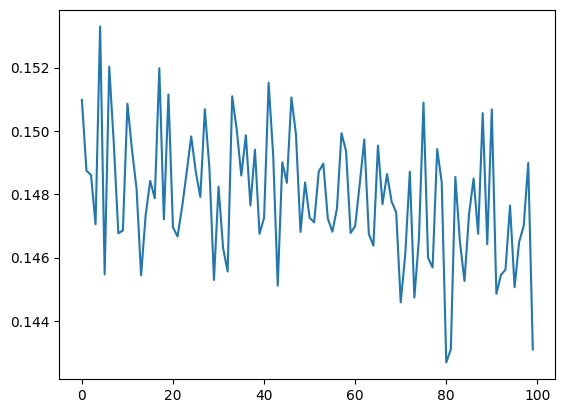

In [16]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'][-100:])), loss_log['up_end_mae'][-100:])
plt.show()

In [ ]:
# torch.save(up_changer.state_dict(), 'tim_files/up_changer.pth')

In [26]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


In [36]:
torch.save(test_predictions, 'submission_files/tim_deep1_pred.pt')

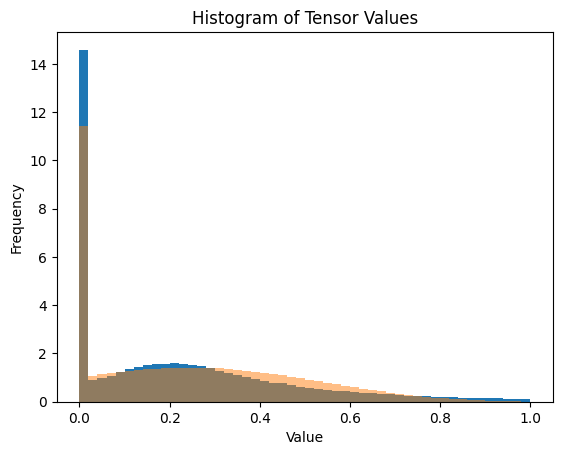

In [34]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

In [35]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep1.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
